[florence-sam](https://huggingface.co/spaces/SkalskiP/florence-sam)<br>
[Florence-2](https://huggingface.co/spaces/gokaygokay/Florence-2)<br>
[sam2](https://ai.meta.com/sam2/)<br>

<img src="https://raw.githubusercontent.com/p-p-p-p/store/main/demo.png">

You can use Florence-2 to detect specific objects, such as a single leaf in an image, by passing a prompt like "a single leaf." Florence-2 will identify and locate all instances of leaves in the image, which can then be passed to the SAM2 model. SAM2 will generate masks for each detected object, isolating them within the image.

Once you have the masks, you can select the one that best matches your prompt (e.g., the first detected leaf) and use OpenCV to create a mask to isolate the leaf from the background. This will allow you to extract only that object from the original image, with the background being white. After that, you can perform spectral reflection of visible light on the extracted leaf to obtain a Reflectance vs. Wavelength graph.



https://www.youtube.com/watch?v=vKG7BQw3H9U
495-570 nm

https://github.com/awesome-spectral-indices/awesome-spectral-indices

In [ ]:
#@title Install required packages and Auto - Restart Session [If you get any pop-up click on cancel]
!git lfs install
%cd /content/
!rm -rf /content/florence-sam
!git clone https://huggingface.co/spaces/SkalskiP/florence-sam
!wget https://treeplantation.com/images/articles/tree-leaves.png
%cd /content/florence-sam
!pip install -r /content/florence-sam/requirements.txt
!pip install gradio==4.36.1
from IPython.display import clear_output
clear_output()
import time
time.sleep(5)
import os
os.kill(os.getpid(), 9)

In [1]:
#@title After seeing the red icon above run from here

In [2]:
#@title <-- Play Audio to active the colab Notebook { display-mode: "form" }

%%html
<b>Press play on the music player to keep the tab alive, then run the cell below</b><br/>
<audio src="https://raw.githubusercontent.com/KoboldAI/KoboldAI-Client/main/colab/silence.m4a" controls>

In [3]:
#@title Utils
%cd /content/florence-sam
import os
from typing import Tuple, Optional

import cv2
import gradio as gr
import numpy as np
import spaces
import supervision as sv
import torch
from PIL import Image
from tqdm import tqdm

from utils.florence import load_florence_model, run_florence_inference, \
    FLORENCE_DETAILED_CAPTION_TASK, \
    FLORENCE_CAPTION_TO_PHRASE_GROUNDING_TASK, FLORENCE_OPEN_VOCABULARY_DETECTION_TASK
from utils.modes import IMAGE_INFERENCE_MODES, IMAGE_OPEN_VOCABULARY_DETECTION_MODE
from utils.sam import load_sam_image_model, run_sam_inference


DEVICE = torch.device("cuda")
# DEVICE = torch.device("cpu")

torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()
if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
FLORENCE_MODEL, FLORENCE_PROCESSOR = load_florence_model(device=DEVICE)
SAM_IMAGE_MODEL = load_sam_image_model(device=DEVICE)
COLORS = ['#FF1493', '#00BFFF', '#FF6347', '#FFD700', '#32CD32', '#8A2BE2']
COLOR_PALETTE = sv.ColorPalette.from_hex(COLORS)
BOX_ANNOTATOR = sv.BoxAnnotator(color=COLOR_PALETTE, color_lookup=sv.ColorLookup.INDEX)
LABEL_ANNOTATOR = sv.LabelAnnotator(
    color=COLOR_PALETTE,
    color_lookup=sv.ColorLookup.INDEX,
    text_position=sv.Position.CENTER_OF_MASS,
    text_color=sv.Color.from_hex("#000000"),
    border_radius=5
)
MASK_ANNOTATOR = sv.MaskAnnotator(
    color=COLOR_PALETTE,
    color_lookup=sv.ColorLookup.INDEX
)
from IPython.display import clear_output
clear_output()

def annotate_image(image, detections):
    output_image = image.copy()
    output_image = MASK_ANNOTATOR.annotate(output_image, detections)
    output_image = BOX_ANNOTATOR.annotate(output_image, detections)
    output_image = LABEL_ANNOTATOR.annotate(output_image, detections)
    return output_image






@torch.inference_mode()
@torch.autocast(device_type="cuda", dtype=torch.bfloat16)
def process_image(image_input, text_input,mode_dropdown=IMAGE_OPEN_VOCABULARY_DETECTION_MODE
) -> Tuple[Optional[Image.Image], Optional[str]]:
    if not image_input:
        gr.Info("Please upload an image.")
        return None, None
    text_input=text_input.lower()
    if mode_dropdown == IMAGE_OPEN_VOCABULARY_DETECTION_MODE:
        if not text_input:
            gr.Info("Please enter a text prompt.")
            return None, None

        texts = [prompt.strip() for prompt in text_input.split(",")]
        detections_list = []
        for text in texts:
            _, result = run_florence_inference(
                model=FLORENCE_MODEL,
                processor=FLORENCE_PROCESSOR,
                device=DEVICE,
                image=image_input,
                task=FLORENCE_OPEN_VOCABULARY_DETECTION_TASK,
                text=text
            )
            detections = sv.Detections.from_lmm(
                lmm=sv.LMM.FLORENCE_2,
                result=result,
                resolution_wh=image_input.size
            )
            detections = run_sam_inference(SAM_IMAGE_MODEL, image_input, detections)
            detections_list.append(detections)

        detections = sv.Detections.merge(detections_list)
        detections = run_sam_inference(SAM_IMAGE_MODEL, image_input, detections)
        # return annotate_image(image_input, detections), None
        return detections



In [159]:
#@title utils part 2
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

def resize_image_with_padding(image,size=(512,512)):
  # Get the dimensions of the original image
  h, w = image.shape[:2]
  width,height=size
  # Calculate the scaling factor to maintain the aspect ratio
  scale = min(width / w, height / h)

  # Resize the image with the calculated scale factor
  new_w = int(w * scale)
  new_h = int(h * scale)
  resized_image = cv2.resize(image, (new_w, new_h))

  # Create a new image with a white background (or any color) and paste the resized image onto it
  padded_image = np.full((width, height, 3), 255, dtype=np.uint8)  # White background (255, 255, 255)

  # Calculate the top-left corner of the image to center it
  x_offset = (width - new_w) // 2
  y_offset = (height - new_h) // 2

  # Place the resized image onto the padded background
  padded_image[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized_image
  return padded_image
def mask_image(pillow_image, detections):
  # Convert the Pillow image to OpenCV format (NumPy array)
  opencv_image = np.array(pillow_image)
  # Convert RGB to BGR (if needed, OpenCV uses BGR by default)
  opencv_image = cv2.cvtColor(opencv_image, cv2.COLOR_RGB2BGR)

  # Extract the detection mask and bounding box
  mask = list(detections[0])[0][1]
  xyxy = list(detections[0])[0][0]
  mask=mask.astype(np.uint8)
  # Convert bounding box coordinates to integers
  x_min, y_min, x_max, y_max = map(int, xyxy)
  # cv2_imshow(opencv_image)

  # Create a white background image of the same size as the cropped image
  white_background = np.ones_like(opencv_image) * 255

  # Apply the resized mask to the cropped image
  masked_roi = cv2.bitwise_and(opencv_image, opencv_image, mask=mask)
  # cv2.imwrite("/content/temp.png",masked_roi)
  # Place the masked ROI onto the white background
  white_background = cv2.bitwise_or(white_background, white_background, mask=cv2.bitwise_not(mask))
  white_background[mask == 1] = masked_roi[mask == 1]
  cropped_image = white_background[y_min:y_max, x_min:x_max]
  cropped_image=resize_image_with_padding(cropped_image,size=(256,256))
  # rgb_image = cv2.cvtColor(white_background, cv2.COLOR_BGR2RGB)
  # cropped_image=cv2.resize(cropped_image,(5
  # cv2_imshow(cropped_image)
  rgb_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)
  print(rgb_image.shape)
  return rgb_image
  # rgb_image = cv2.cvtColor(white_background, cv2.COLOR_BGR2RGB)
  # pillow_mask_image = Image.fromarray(rgb_image)
  # return pillow_mask_image


import json
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import uuid
import shutil
def clean_folder(folder_name):
  if os.path.exists(folder_name):
    shutil.rmtree(folder_name)
  os.makedirs(folder_name)
# Create the directory if it doesn't exist
if not os.path.exists("/content/Dataset"):
    os.mkdir("/content/Dataset")

def get_file_name():
    random_uuid = str(uuid.uuid4())[:10]
    return f"/content/Dataset/{random_uuid}"
#Spectral Reflection of Visible Light on Leaves
def extract_rgb_values_with_numpy(img_array,plant_name=None):
    random_file_name = get_file_name()
    json_filename = f"{random_file_name}.json"
    graph_image_path = f"{random_file_name}_mask.png"
    mask_image_path = f"{random_file_name}.png"

    # Save the image
    bgr_image = cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR)
    cv2.imwrite(mask_image_path, bgr_image)

    # Dictionary to store pixel information, reflectance, and wavelengths
    store_data = {
        "pixel_info": [],
        "reflectance_values": [],
        "wavelength_values": []
    }

    # Get the dimensions of the image
    height, width, _ = img_array.shape

    # Iterate through each pixel
    for y in range(height):
        for x in range(width):
            # Get the RGB values
            r, g, b = map(int, img_array[y, x])

            def my_map(x, in_min, in_max, out_min, out_max):
                return int((x - in_min) * (out_max - out_min) / (in_max - in_min) + out_min)

            # Map 8 bits value of R,G,B (0 to 255) to their bandwidth of wavelength
            R = my_map(r, 0, 255, 499, 700)  # rgb 0 = 499 nm, rgb 255 = 700
            G = my_map(g, 0, 255, 440 , 580)  # rgb 0 = 440 nm, rgb 255 = 580
            B = my_map(b, 0, 255, 380, 490)  # rgb 0 = 440 nm, rgb 255 = 490

            # Mean of constituent wavelengths
            wavelength = (R + G + B) / 3
            wavelength_rounded = round(wavelength, 2)

            # Calculate reflectance
            reflectance = int(0.2125 * r + 0.7154 * g + 0.0721 * b)
            r_percentage = (reflectance / 320) * 100
            r_percentage_rounded = round(r_percentage, 2)

            # Store pixel information, reflectance, and wavelength as a tuple
            store_data["pixel_info"].append(((x, y), r_percentage_rounded, wavelength_rounded))

    # Sort the list based on wavelengths
    sorted_info = sorted(store_data["pixel_info"], key=lambda x: x[2])

    # Create a dictionary to store the sorted data
    result_dict = {}

    # Iterate through each item in g_store
    for item in sorted_info:
        pixel = item[0]
        r = item[1]
        w = item[2]

        # Check if (r, w) is already in the dictionary
        if (r, w) not in result_dict:
            result_dict[(r, w)] = [pixel]
        else:
            result_dict[(r, w)].append(pixel)
    reflectance = []
    wavelength = []

    # Iterate through the keys of the result_dict
    for (r, w) in result_dict.keys():
        reflectance.append(r)
        wavelength.append(w)

    # Sort the reflectance and wavelength lists
    sorted_reflectance = sorted(reflectance)
    sorted_wavelength = sorted(wavelength)

    # Plotting the Reflectance values
    plt.figure(figsize=(14, 8))
    plt.plot(sorted_wavelength, sorted_reflectance, marker='o', label='Reflectance')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Reflectance')
    plt.title('Reflectance vs. Wavelength')
    plt.xlim(380, 700)  # Set x-axis limits
    plt.legend()
    plt.grid(True)

    # Save the plot to a file
    plt.savefig(graph_image_path)  # Specify your desired filename and format
    plt.close()  # Close the plot to free up memory
    # plt.show()  # Close the plot to free up memory

    # Create a new dictionary excluding 'pixel_info'
    reduced_data = {
        "plant_name": plant_name,
        "image_path": os.path.basename(mask_image_path),
        "graph_path": os.path.basename(graph_image_path),
        "reflectance": reflectance,
        "wavelength": wavelength
    }
    print(len(reflectance))
    print(len(wavelength))
    # Save the reduced dictionary to a JSON file
    with open(json_filename, 'w') as json_file:
        json.dump(reduced_data, json_file, indent=4)  # indent for pretty printing

    # temp_json_compatible = {
    #     str(key): value for key, value in result_dict.items()
    # }

    # # Save the dictionary to a JSON file
    # with open('/content/temp.json', 'w') as file:
    #     json.dump(temp_json_compatible, file, indent=4)

    return mask_image_path,graph_image_path,json_filename
# Example usage
temp=None
def gradio_image_process(pillow_image,prompt,plant_name=None):
  detections=process_image(pillow_image , prompt)
  opencv_mask_image=mask_image(pillow_image, detections)
  mask_image_path,graph_image_path,json_filename=extract_rgb_values_with_numpy(opencv_mask_image,plant_name)
  return mask_image_path,graph_image_path,json_filename


In [160]:
clean_folder("/content/Dataset")

(256, 256, 3)
1536
1536


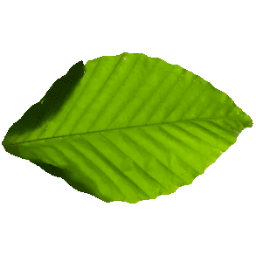

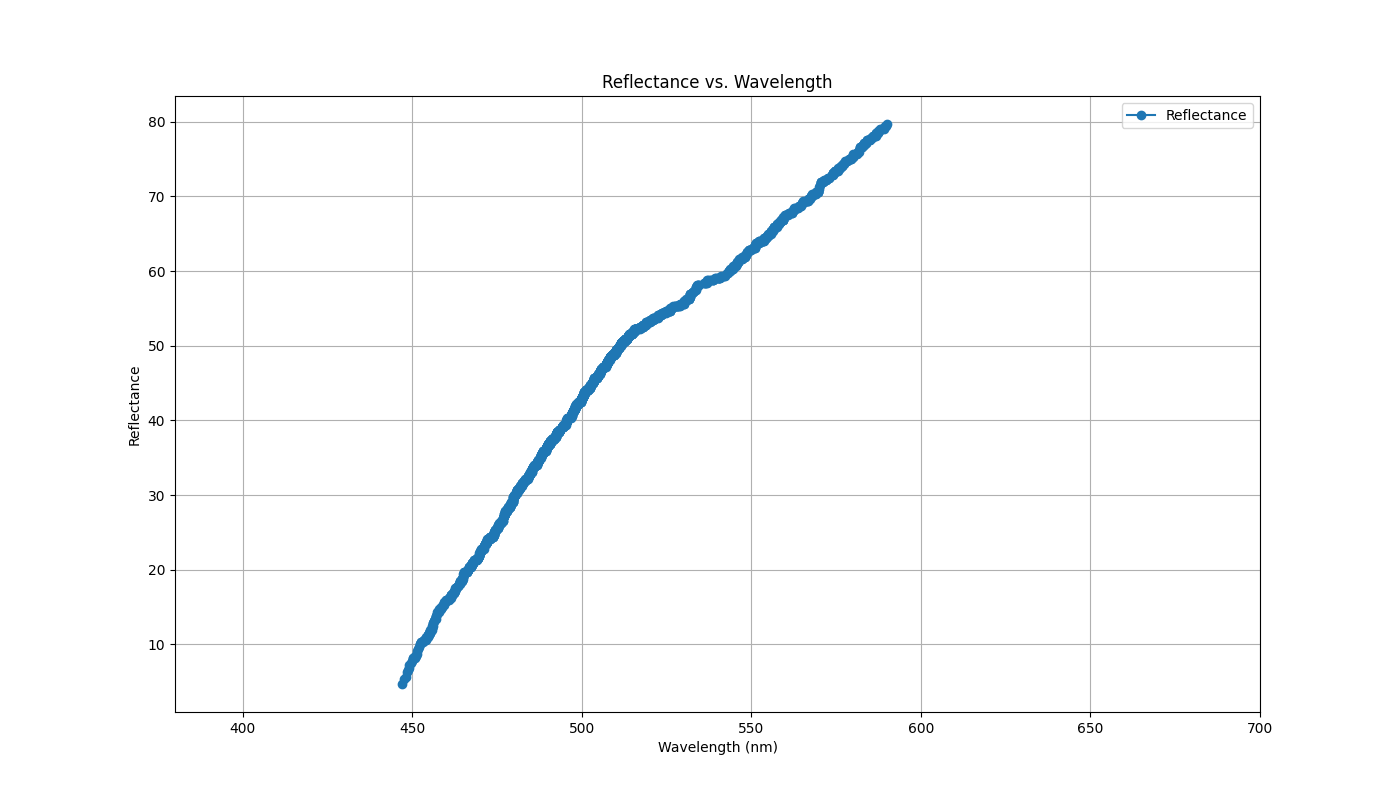

In [161]:

image_path = '/content/tree-leaves.png'  # @param {type: "string"}
prompt = 'a single leaf'  # @param {type: "string"}
Plant_Name = 'None'  # @param {type: "string"}

pillow_image = Image.open(image_path)
if pillow_image.mode != 'RGB':
    pillow_image = pillow_image.convert('RGB')
mask_image_path,graph_image_path,json_filename=gradio_image_process(pillow_image,prompt,Plant_Name)
cv2_imshow(cv2.imread(mask_image_path))
cv2_imshow(cv2.imread(graph_image_path))

In [155]:
from google.colab import files
files.download(json_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [162]:
#@title Gradio API Interface

import gradio as gr
gradio_examples = [["/content/tree-leaves.png","a single leaf","None"]]
gradio_input=[gr.Image(label="Upload or Capture Image",type='pil',sources=['upload', 'webcam'],mirror_webcam=False),gr.Textbox(label="Text prompt",value="a single leaf"),gr.Textbox(label="Plant Name",value="None")]
gradio_output=[gr.Image(label="Detected leaf"),gr.Image(label="Reflectance vs. Wavelength graph"),gr.File(label="Download Json File")]
gradio_interface = gr.Interface(fn=gradio_image_process, inputs=gradio_input,outputs=gradio_output , title="Spectral Reflection of Visible Light on Leaves",examples=gradio_examples,cache_examples=True)
gradio_interface.queue().launch(share=True,debug=False)



Caching examples at: '/content/florence-sam/gradio_cached_examples/55'
Caching example 1/1
(256, 256, 3)
1536
1536
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://90cef6508d86516aa1.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
